In [48]:
import numpy as np 
import pandas as pd
import os
import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=False)
from wordcloud import WordCloud
from geopy.geocoders import Nominatim
from folium.plugins import HeatMap
import folium
from tqdm import tqdm
import re
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.models import Sequential
# from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.colors as mcolors
from sklearn.manifold import TSNE
from gensim.models import word2vec
import nltk
# Any results you write to the current directory are saved as output.

In [49]:
df = pd.read_csv('zomato.csv')

In [50]:
df.head()

url  \
0  https://www.zomato.com/bangalore/jalsa-banasha...   
1  https://www.zomato.com/bangalore/spice-elephan...   
2  https://www.zomato.com/SanchurroBangalore?cont...   
3  https://www.zomato.com/bangalore/addhuri-udupi...   
4  https://www.zomato.com/bangalore/grand-village...   

                                             address                   name  \
0  942, 21st Main Road, 2nd Stage, Banashankari, ...                  Jalsa   
1  2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...         Spice Elephant   
2  1112, Next to KIMS Medical College, 17th Cross...        San Churro Cafe   
3  1st Floor, Annakuteera, 3rd Stage, Banashankar...  Addhuri Udupi Bhojana   
4  10, 3rd Floor, Lakshmi Associates, Gandhi Baza...          Grand Village   

  online_order book_table   rate  votes                             phone  \
0          Yes        Yes  4.1/5    775    080 42297555\r\n+91 9743772233   
1          Yes         No  4.1/5    787                      080 41714161   
2          Yes         No  3.8/5    918                    +91 9663487993   
3           No         No  3.7/5     88                    +91 9620009302   
4           No         No  3.8/5    166  +91 8026612447\r\n+91 9901210005   

       location            rest_type  \
0  Banashankari        Casual Dining   
1  Banashankari        Casual Dining   
2  Banashankari  Cafe, Casual Dining   
3  Banashankari          Quick Bites   
4  Basavanagudi        Casual Dining   

                                          dish_liked  \
0  Pasta, Lunch Buffet, Masala Papad, Paneer Laja...   
1  Momos, Lunch Buffet, Chocolate Nirvana, Thai G...   
2  Churros, Cannelloni, Minestrone Soup, Hot Choc...   
3                                        Masala Dosa   
4                                Panipuri, Gol Gappe   

                         cuisines approx_cost(for two people)  \
0  North Indian, Mughlai, Chinese                         800   
1     Chinese, North Indian, Thai                         800   
2          Cafe, Mexican, Italian                         800   
3      South Indian, North Indian                         300   
4        North Indian, Rajasthani                         600   

                                        reviews_list menu_item  \
0  [('Rated 4.0', 'RATED\n  A beautiful place to ...        []   
1  [('Rated 4.0', 'RATED\n  Had been here for din...        []   
2  [('Rated 3.0', "RATED\n  Ambience is not that ...        []   
3  [('Rated 4.0', "RATED\n  Great food and proper...        []   
4  [('Rated 4.0', 'RATED\n  Very good restaurant ...        []   

  listed_in(type) listed_in(city)  
0          Buffet    Banashankari  
1          Buffet    Banashankari  
2          Buffet    Banashankari  
3          Buffet    Banashankari  
4          Buffet    Banashankari

# Popular Supply Chains

Text(0.5, 0, 'Number of outlets')

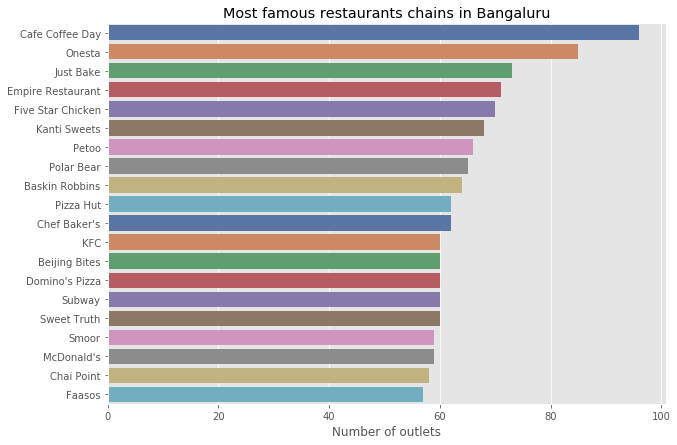

In [51]:


plt.figure(figsize=(10,7))
chains=df['name'].value_counts()[:20]
sns.barplot(x=chains,y=chains.index,palette='deep')
plt.title("Most famous restaurants chains in Bangaluru")
plt.xlabel("Number of outlets")



# Rating distribution

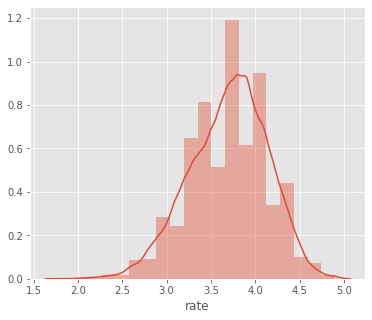

In [52]:
plt.figure(figsize=(6,5))
rating=df['rate'].dropna().apply(lambda x : float(x.split('/')[0]) if (len(x)>3)  else np.nan ).dropna()
sns.distplot(rating,bins=20)

# Rating vs Cost for for two

In [53]:


cost_dist=df[['rate','approx_cost(for two people)','online_order']].dropna()
cost_dist['rate']=cost_dist['rate'].apply(lambda x: float(x.split('/')[0]) if len(x)>3 else 0)
cost_dist['approx_cost(for two people)']=cost_dist['approx_cost(for two people)'].apply(lambda x: int(x.replace(',','')))



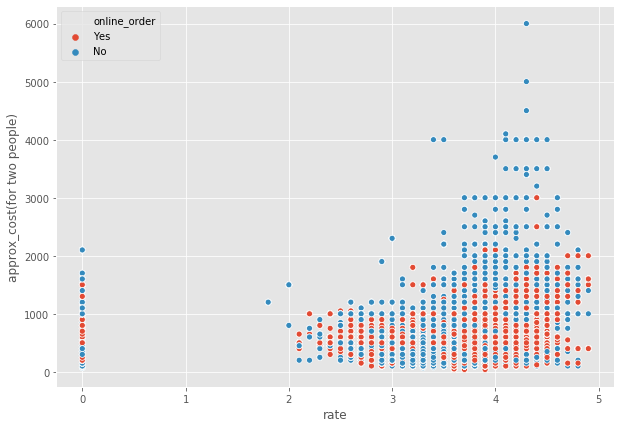

In [54]:
plt.figure(figsize=(10,7))
sns.scatterplot(x="rate",y='approx_cost(for two people)',hue='online_order',data=cost_dist)
plt.show()

## As cost for two increases rating also increases

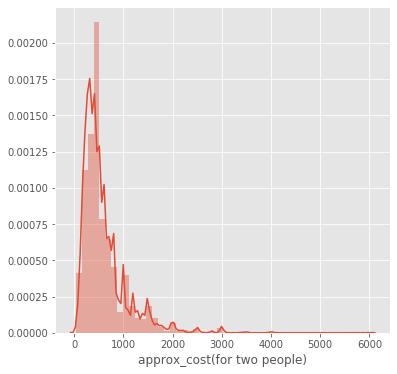

In [55]:
plt.figure(figsize=(6,6))
sns.distplot(cost_dist['approx_cost(for two people)'])
plt.show()

# Popular restaurant types

Text(0.5, 0, 'count')

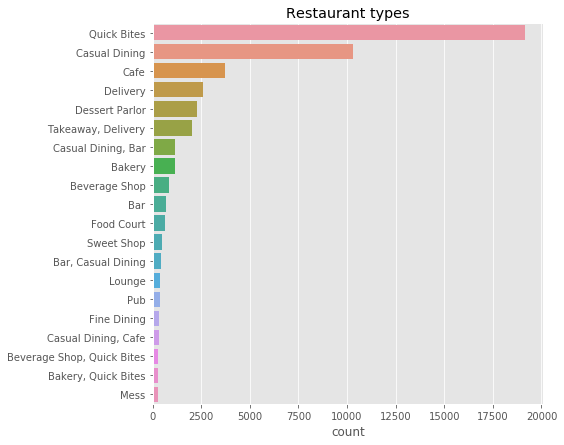

In [56]:
plt.figure(figsize=(7,7))
rest=df['rest_type'].value_counts()[:20]
sns.barplot(rest,rest.index)
plt.title("Restaurant types")
plt.xlabel("count")

# Popular Locations

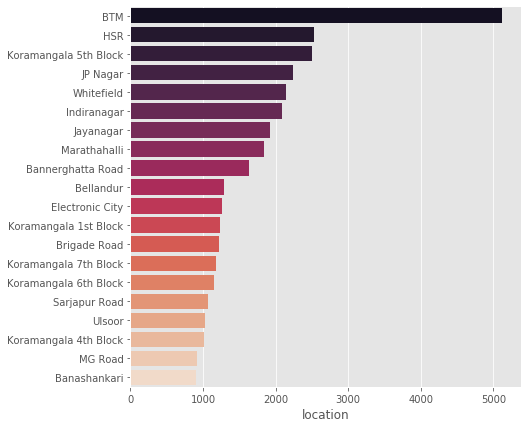

In [57]:
plt.figure(figsize=(7,7))
Rest_locations=df['location'].value_counts()[:20]
sns.barplot(Rest_locations,Rest_locations.index,palette="rocket")

In [58]:
locations=pd.DataFrame({"Name":df['location'].unique()})
locations['Name']=locations['Name'].apply(lambda x: "Bangalore " + str(x))
lat_lon=[]
geolocator=Nominatim(user_agent="app")
for location in locations['Name']:
    location = geolocator.geocode(location)
    if location is None:
        lat_lon.append(np.nan)
    else:    
        geo=(location.latitude,location.longitude)
        lat_lon.append(geo)


locations['geo_loc']=lat_lon
locations.to_csv('locations.csv',index=False)



In [59]:
locations["Name"]=locations['Name'].apply(lambda x :  x.replace("Bangalore","")[1:])

In [60]:
Rest_locations=pd.DataFrame(df['location'].value_counts().reset_index())
Rest_locations.columns=['Name','count']
Rest_locations=Rest_locations.merge(locations,on='Name',how="left").dropna()
Rest_locations['count'].max()

5124

In [61]:
def generateBaseMap(default_location=[12.97, 77.59], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [62]:


lat,lon=zip(*np.array(Rest_locations['geo_loc']))
Rest_locations['lat']=lat
Rest_locations['lon']=lon
basemap=generateBaseMap()
HeatMap(Rest_locations[['lat','lon','count']].values.tolist(),zoom=20,radius=15).add_to(basemap)



In [63]:
basemap

## Mostly concentrated in middle of Bangalore

# Most common cuisines

Text(0.5, 1.0, 'Most popular cuisines of Bangalore')

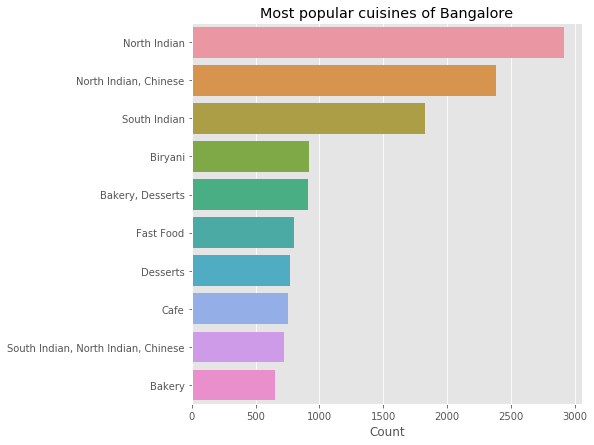

In [64]:
plt.figure(figsize=(7,7))
cuisines=df['cuisines'].value_counts()[:10]
sns.barplot(cuisines,cuisines.index)
plt.xlabel('Count')
plt.title("Most popular cuisines of Bangalore")

## We can observe that North Indian,chinese,South Indian and Biriyani are most common.

# Most Liked Dishes

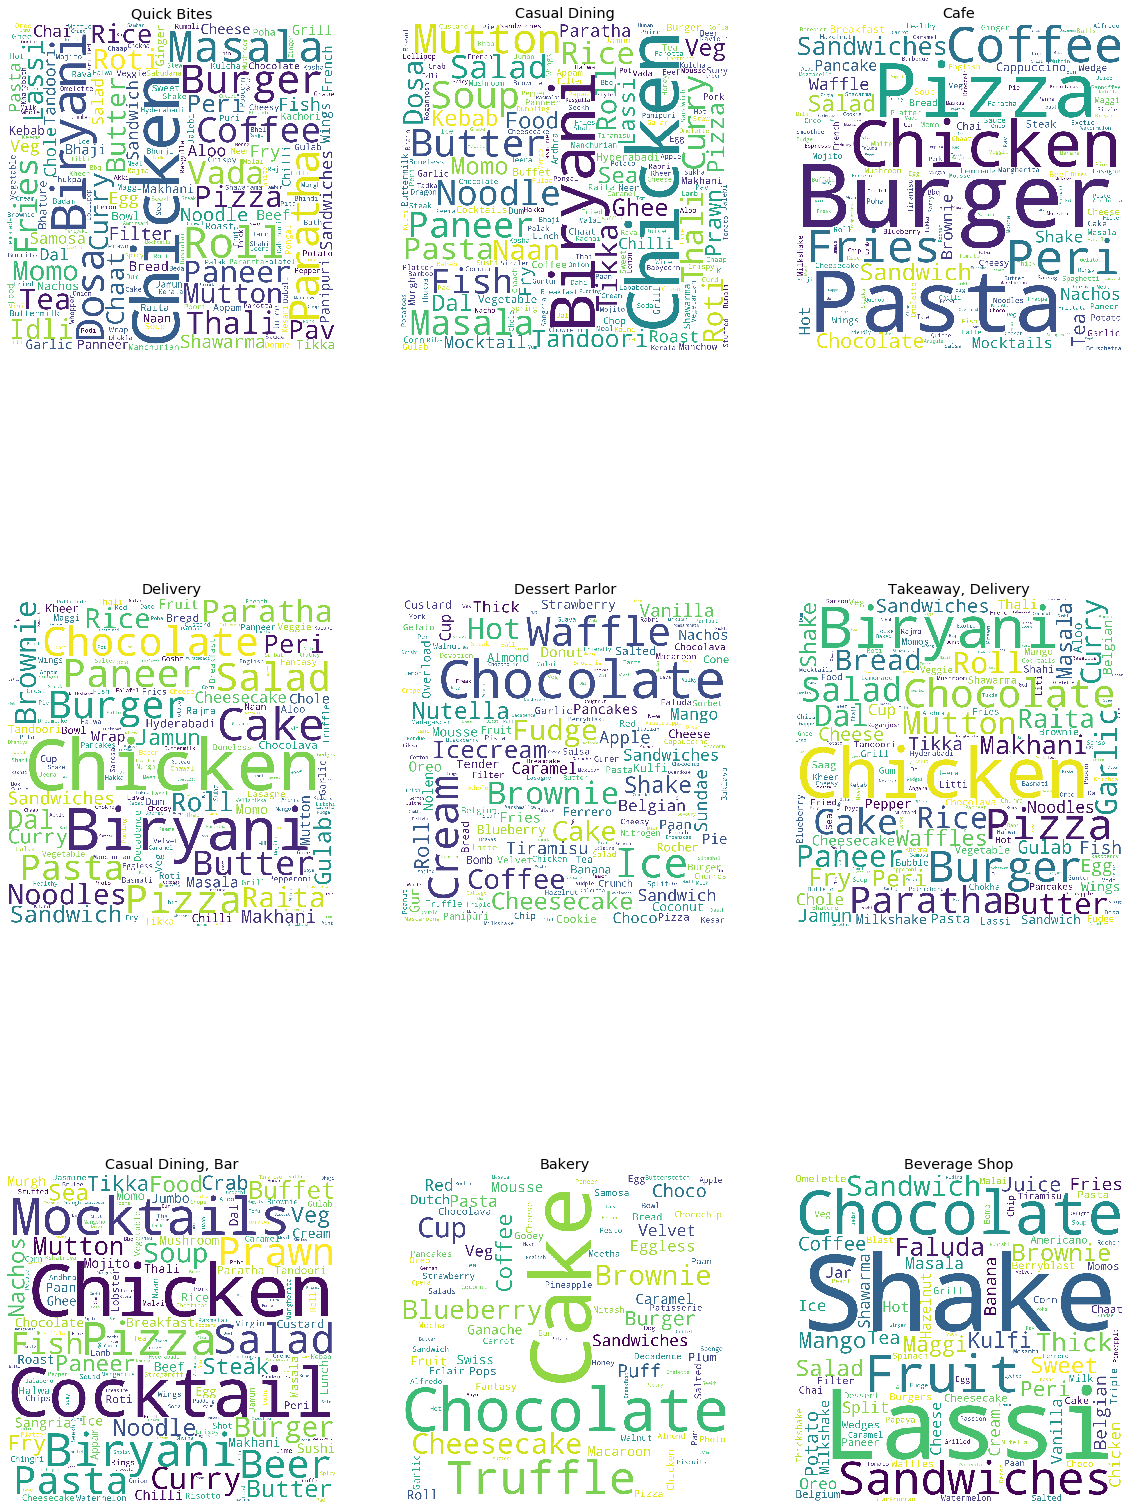

In [66]:
df['dish_liked']=df['dish_liked'].apply(lambda x : x.split(',') if type(x)==str else [''])

rest=df['rest_type'].value_counts()[:9].index
def produce_wordcloud(rest):
    
    plt.figure(figsize=(20,30))
    for i,r in enumerate(rest):
        plt.subplot(3,3,i+1)
        corpus=df[df['rest_type']==r]['dish_liked'].values.tolist()
        corpus=','.join(x  for list_words in corpus for x in list_words)
        wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1500, height=1500).generate(corpus)
        plt.imshow(wordcloud)
        plt.title(r)
        plt.axis("off")
        

        
        
produce_wordcloud(rest)

# Review Analysis

In [67]:
all_ratings = []

for name,ratings in tqdm(zip(df['name'],df['reviews_list'])):
    ratings = eval(ratings)
    for score, doc in ratings:
        if score:
            score = score.strip("Rated").strip()
            doc = doc.strip('RATED').strip()
            score = float(score)
            all_ratings.append([name,score, doc])

51717it [00:17, 2944.38it/s]


In [68]:
rating_df=pd.DataFrame(all_ratings,columns=['name','rating','review'])
rating_df['review']=rating_df['review'].apply(lambda x : re.sub('[^a-zA-Z0-9\s]',"",x))

In [69]:
rating_df.to_csv("Ratings.csv")

In [70]:
rating_df.head()

name  rating                                             review
0  Jalsa     4.0  A beautiful place to dine inThe interiors take...
1  Jalsa     4.0  I was here for dinner with my family on a week...
2  Jalsa     2.0  Its a restaurant near to Banashankari BDA Me a...
3  Jalsa     4.0  We went here on a weekend and one of us had th...
4  Jalsa     5.0  The best thing about the place is its ambiance...

## Creating another dataframe for reviews

# Topic Modelling

## Topic Modelling for positive reviews (ratings > 2.5)

In [71]:
rating_df['sent']=rating_df['rating'].apply(lambda x: 1 if int(x)>2.5 else 0)

### we will remove stopwords
### Lemmatize each word
### Create corpus
### Tokenize them

In [72]:
stops=stopwords.words('english')
lem=WordNetLemmatizer()
corpus=' '.join(lem.lemmatize(x) for x in rating_df[rating_df['sent']==1]['review'][:3000] if x not in stops)
tokens=word_tokenize(corpus)

In [73]:
# we will use Termfrequency Inverse doc frequency(Tfidf) to vectorize the tokens.


vect=TfidfVectorizer()
vect_fit=vect.fit(tokens)
    



## LDA for topic modelling

In [74]:
id_map=dict((v,k) for k,v in vect.vocabulary_.items())
vectorized_data=vect_fit.transform(tokens)
gensim_corpus=gensim.matutils.Sparse2Corpus(vectorized_data,documents_columns=False)
ldamodel = gensim.models.ldamodel.LdaModel(gensim_corpus,id2word=id_map,num_topics=5,random_state=34,passes=25)

## Word counts of topic keywords
### When it comes to the keywords in the topics, the importance (weights) of the keywords matters. Along with that, how frequently the words have appeared in the documents is also interesting to look.

In [75]:
counter=Counter(corpus)

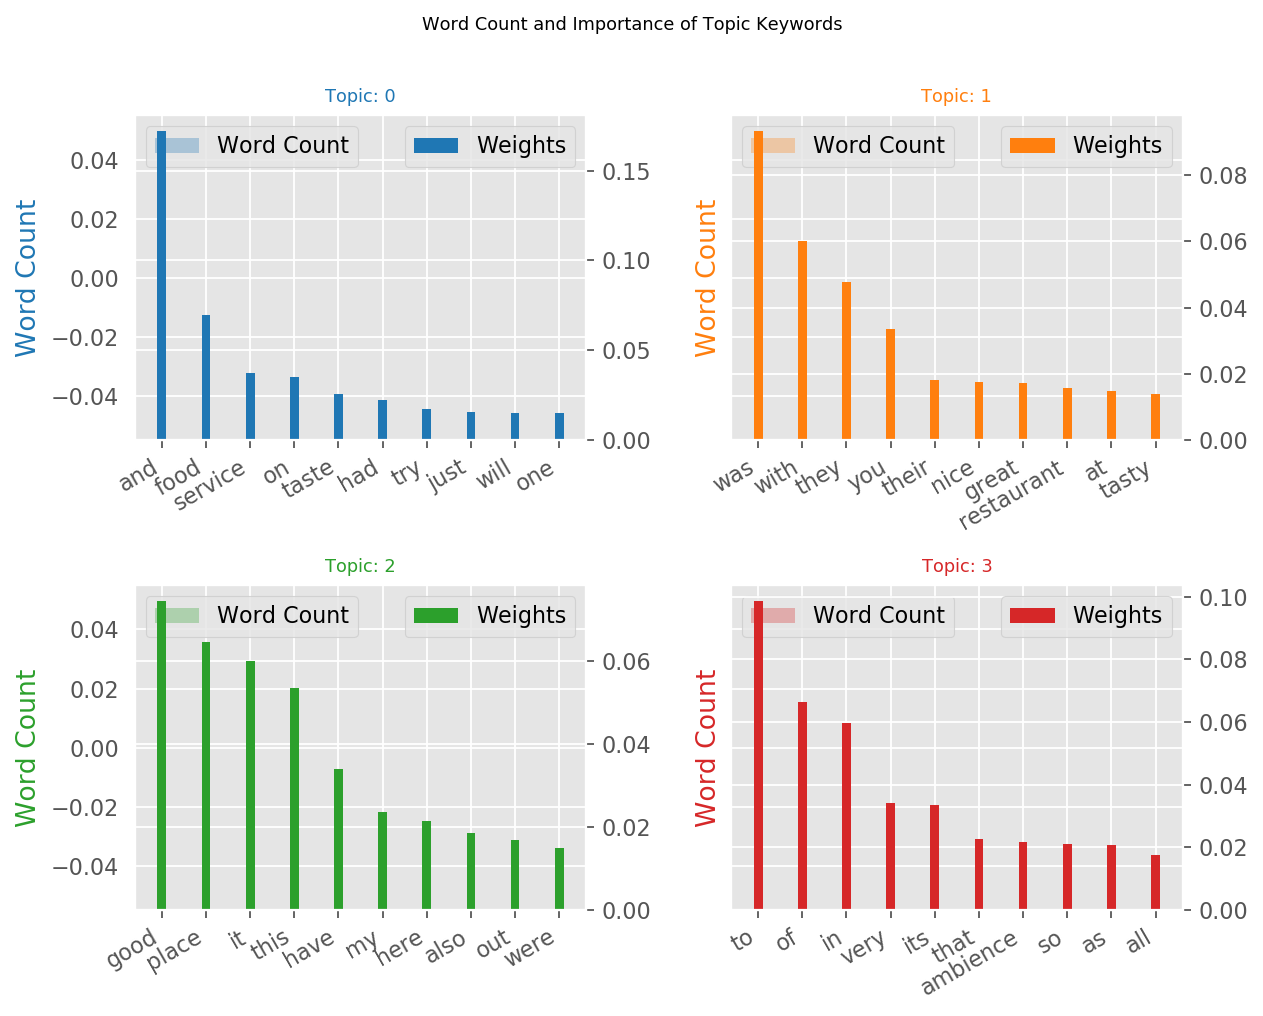

In [76]:
out=[]
topics=ldamodel.show_topics(formatted=False)
for i,topic in topics:
    for word,weight in topic:
        out.append([word,i,weight,counter[word]])

dataframe = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count']) 

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(8,6), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=dataframe.loc[dataframe.topic_id==i, :], color=cols[i], width=0.3, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=dataframe.loc[dataframe.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    #ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=8)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(dataframe.loc[dataframe.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=8, y=1.05)    
plt.show()

## Topic modeling for negative comments

In [79]:
stops=stopwords.words('english')
lem=WordNetLemmatizer()
corpus=' '.join(lem.lemmatize(x) for x in rating_df[rating_df['sent']==0]['review'][:3000] if x not in stops)
tokens=word_tokenize(corpus)

In [80]:
vect=TfidfVectorizer()
vect_fit=vect.fit(tokens)
id_map=dict((v,k) for k,v in vect.vocabulary_.items())
vectorized_data=vect_fit.transform(tokens)
gensim_corpus=gensim.matutils.Sparse2Corpus(vectorized_data,documents_columns=False)
ldamodel = gensim.models.ldamodel.LdaModel(gensim_corpus,id2word=id_map,num_topics=5,random_state=34,passes=25)

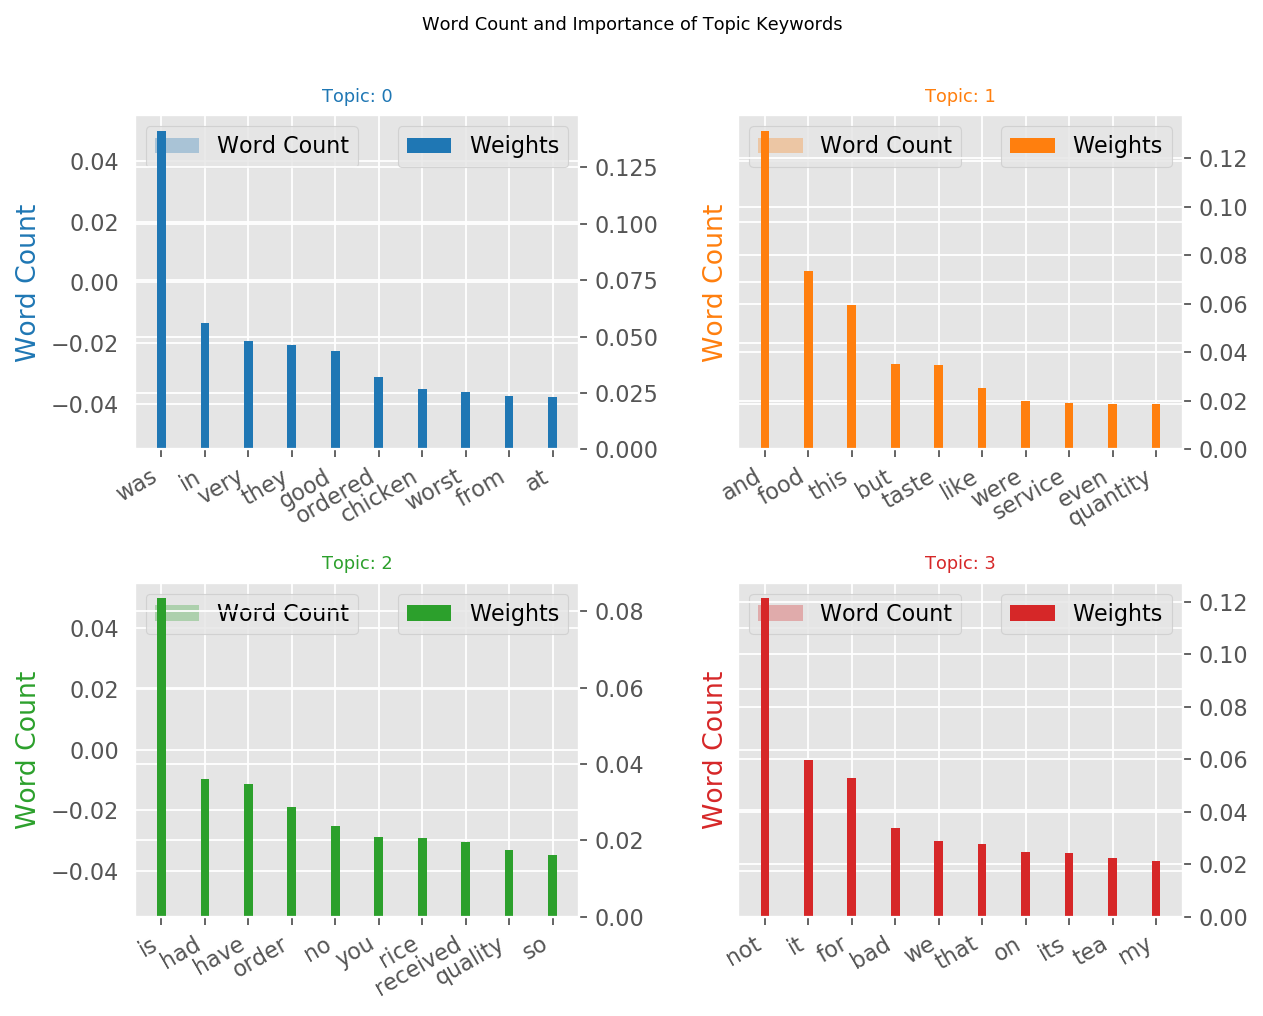

In [81]:
counter=Counter(corpus)
out=[]
topics=ldamodel.show_topics(formatted=False)
for i,topic in topics:
    for word,weight in topic:
        out.append([word,i,weight,counter[word]])

dataframe = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        


# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(8,6), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=dataframe.loc[dataframe.topic_id==i, :], color=cols[i], width=0.3, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=dataframe.loc[dataframe.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    #ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=8)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(dataframe.loc[dataframe.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=8, y=1.05)    
plt.show()

###    We can clearly observe the difference between the two types of comments
###    The words used are clearly distinguishable.
###    The words used in negative comments are clearly critisizing.
###    The word used in positive comments are clearly appreciating.

# T-SNE of Reviews

### (t-SNE) t-Distributed Stochastic Neighbor Embedding is a non-linear dimensionality reduction algorithm used for exploring high-dimensional data. It maps multi-dimensional data to two or more dimensions suitable for human observation. With help of the t-SNE algorithms, you may have to plot fewer exploratory data analysis plots next time you work with high dimensional data

### For that we will first lemmatize and tokenize each reviews and build a corpus out of it.

In [82]:
stops=set(stopwords.words('english'))
lem=WordNetLemmatizer()
corpus=[]
for review in tqdm(rating_df['review'][:10000]):
    words=[]
    for x in word_tokenize(review):
        x=lem.lemmatize(x.lower())
        if x not in stops:
            words.append(x)
            
    corpus.append(words)


100%|██████████| 10000/10000 [00:06<00:00, 1500.04it/s]


Now we will use word2vec to represent each word as a vector.

In [83]:
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=200, workers=4)

In [84]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(10, 10)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/home/aditya/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



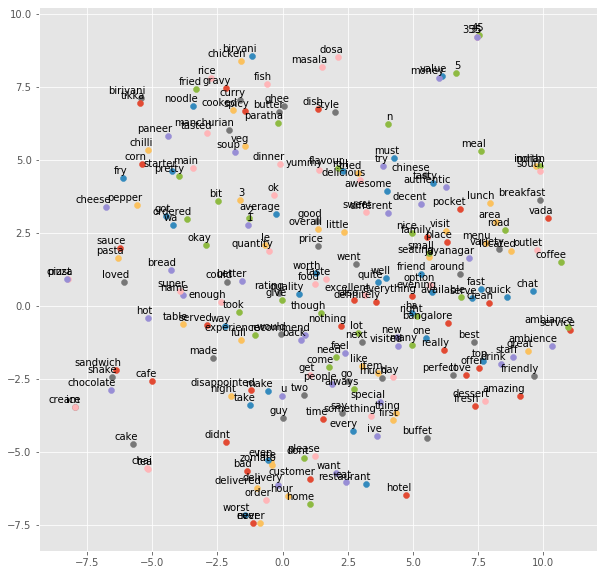

In [85]:
tsne_plot(model)

## T-SNE of adjectivs used in postive reviews

In [86]:
postive=rating_df[rating_df['rating']>3]['review'][:2000]
negative=rating_df[rating_df['rating']<2.5]['review'][:2000]

def return_corpus(df):
    corpus=[]
    for review in df:
        tagged=nltk.pos_tag(word_tokenize(review))
        adj=[]
        for x in tagged:
            if x[1]=='JJ':
                adj.append(x[0])
        corpus.append(adj)
    return corpus

### Wow,we can observe all the adjective used in the postive reviews represented in the 2D space.

/home/aditya/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



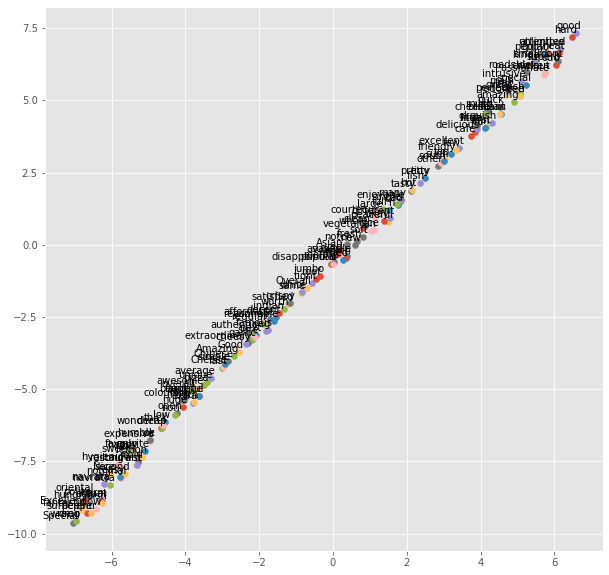

In [88]:


corpus=return_corpus(postive)
model = word2vec.Word2Vec(corpus, size=100, min_count=10,window=20, workers=4)
tsne_plot(model)

